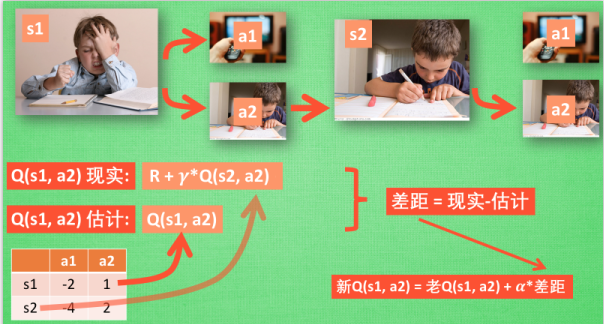

同样, 我们会经历正在写作业的状态 s1, 然后再挑选一个带来最大潜在奖励的动作 a2, 这样我们就到达了继续写作业状态 s2, 而在这一步, 如果你用的是 Q learning, 你会观看一下在 s2 上选取哪一个动作会带来最大的奖励, 但是在真正要做决定时, 却不一定会选取到那个带来最大奖励的动作, Q-learning 在这一步只是估计了一下接下来的动作值. **而 Sarsa 是实践派, 他说到做到, 在 s2 这一步估算的动作也是接下来要做的动作**. 所以 Q(s1, a2) 现实的计算值, 我们也会稍稍改动, 去掉maxQ, 取而代之的是在 s2 上我们实实在在选取的 a2 的 Q 值. 最后像 Q learning 一样, 求出现实和估计的差距 并更新 Q 表里的 Q(s1, a2).

Q learning和Sarsa算法的区别：
Sarsa是在线学习，Q learning是离线学习：
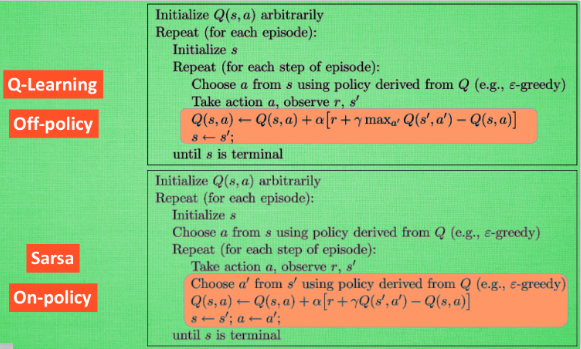

从算法来看, 这就是他们两最大的不同之处了. 因为 Sarsa 是说到做到型, 所以我们也叫他 on-policy, 在线学习（所有都是自己玩，然后学习）, 学着自己在做的事情. 而 Q learning 是说到但并不一定做到, 所以它也叫作 Off-policy, 离线学习（可能会看别人怎么玩，学习）. **而因为有了 maxQ, Q-learning 也是一个特别勇敢的算法**.

为什么说他勇敢呢, 因为 Q learning 机器人 永远都会选择最近的一条通往成功的道路, 不管这条路会有多危险. 而 Sarsa 则是相当保守, 他会选择离危险远远的, 拿到宝藏是次要的, 保住自己的小命才是王道. 这就是使用 Sarsa 方法的不同之处.（现实生活中可能用Sarsa更好些，因为每次掉进坑就要损耗一个Agent，成本太高）

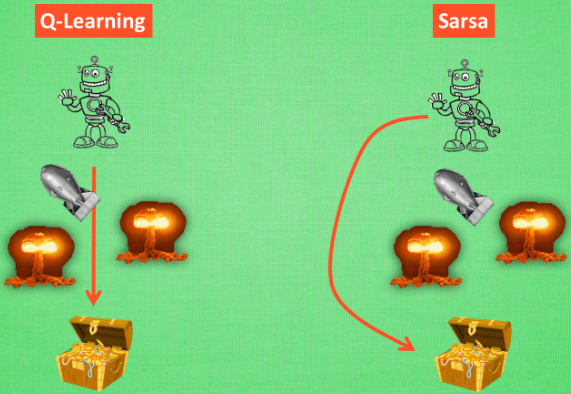

Sarsa算法（它也有ε，10%概率选择随机action）：
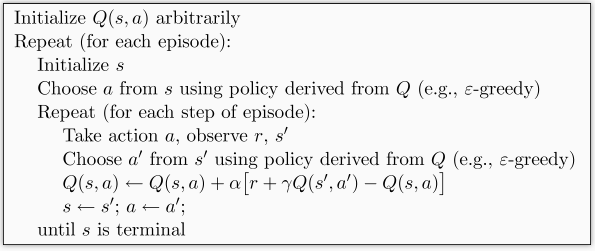

In [1]:
"""
This part of code is the Q learning brain, which is a brain of the agent.
All decisions are made in here.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""

import numpy as np
import pandas as pd


class RL(object):
    def __init__(self, action_space, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = action_space  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy

        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )

    def choose_action(self, observation):
        self.check_state_exist(observation)
        # action selection
        if np.random.rand() < self.epsilon:
            # choose best action
            state_action = self.q_table.loc[observation, :]
            # some actions may have the same value, randomly choose on in these actions
            action = np.random.choice(state_action[state_action == np.max(state_action)].index)
        else:
            # choose random action
            action = np.random.choice(self.actions)
        return action

    def learn(self, *args):
        pass


# off-policy
class QLearningTable(RL):
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        super(QLearningTable, self).__init__(actions, learning_rate, reward_decay, e_greedy)

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update


# on-policy
class SarsaTable(RL):

    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        super(SarsaTable, self).__init__(actions, learning_rate, reward_decay, e_greedy)

    def learn(self, s, a, r, s_, a_): #sarsa算法的由来（sarsa，比Q learning多输入和a_：下一个action也被用来学习）
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            # 不是选择Q最大的action，而是采取下一个行动的值
            q_target = r + self.gamma * self.q_table.loc[s_, a_]  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update

In [2]:
"""
Reinforcement learning maze example.
Red rectangle:          explorer.
Black rectangles:       hells       [reward = -1].
Yellow bin circle:      paradise    [reward = +1].
All other states:       ground      [reward = 0].
This script is the environment part of this example.
The RL is in RL_brain.py.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""


import numpy as np
import time
import sys
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk


UNIT = 40   # pixels
MAZE_H = 4  # grid height
MAZE_W = 4  # grid width


class Maze(tk.Tk, object):
    def __init__(self):
        super(Maze, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.title('maze')
        self.geometry('{0}x{1}'.format(MAZE_W * UNIT, MAZE_H * UNIT))
        self._build_maze()

    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',
                           height=MAZE_H * UNIT,
                           width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([UNIT * 2, UNIT])
        self.hell1 = self.canvas.create_rectangle(
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
        # hell
        hell2_center = origin + np.array([UNIT, UNIT * 2])
        self.hell2 = self.canvas.create_rectangle(
            hell2_center[0] - 15, hell2_center[1] - 15,
            hell2_center[0] + 15, hell2_center[1] + 15,
            fill='black')

        # create oval
        oval_center = origin + UNIT * 2
        self.oval = self.canvas.create_oval(
            oval_center[0] - 15, oval_center[1] - 15,
            oval_center[0] + 15, oval_center[1] + 15,
            fill='yellow')

        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')

        # pack all
        self.canvas.pack()

    def reset(self):
        self.update()
        time.sleep(0.5)
        self.canvas.delete(self.rect)
        origin = np.array([20, 20])
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')
        # return observation
        return self.canvas.coords(self.rect)

    def step(self, action):
        s = self.canvas.coords(self.rect)
        base_action = np.array([0, 0])
        if action == 0:   # up
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:   # down
            if s[1] < (MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.rect, base_action[0], base_action[1])  # move agent

        s_ = self.canvas.coords(self.rect)  # next state

        # reward function
        if s_ == self.canvas.coords(self.oval):
            reward = 1
            done = True
            s_ = 'terminal'
        elif s_ in [self.canvas.coords(self.hell1), self.canvas.coords(self.hell2)]:
            reward = -1
            done = True
            s_ = 'terminal'
        else:
            reward = 0
            done = False

        return s_, reward, done

    def render(self):
        time.sleep(0.1)
        self.update()

In [4]:
"""
Sarsa is a online updating method for Reinforcement learning.
Unlike Q learning which is a offline updating method, Sarsa is updating while in the current trajectory.
You will see the sarsa is more coward when punishment is close because it cares about all behaviours,
while q learning is more brave because it only cares about maximum behaviour.
"""

def update():
    for episode in range(100):
        # initial observation
        observation = env.reset()

        # RL choose action based on observation
        action = RL.choose_action(str(observation))

        while True:
            # fresh env
            env.render()

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)

            # RL choose action based on next observation
            action_ = RL.choose_action(str(observation_))

            # RL learn from this transition (s, a, r, s, a) ==> 和Q learning不同之处：Sarsa要考虑下一个state和action
            RL.learn(str(observation), action, reward, str(observation_), action_)

            # swap observation and action
            observation = observation_
            action = action_

            # break while loop when end of this episode
            if done:
                break

    # end of game
    print('game over')
    env.destroy()

if __name__ == "__main__":
    env = Maze()
    RL = SarsaTable(actions=list(range(env.n_actions)))

    env.after(100, update)
    env.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\OS\Anaconda3\envs\rl_env\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\OS\Anaconda3\envs\rl_env\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-4-b1b4243973eb>", line 21, in update
    observation_, reward, done = env.step(action)
  File "<ipython-input-2-7a97a173488c>", line 94, in step
    s = self.canvas.coords(self.rect)
  File "C:\Users\OS\Anaconda3\envs\rl_env\lib\tkinter\__init__.py", line 2469, in coords
    self.tk.call((self._w, 'coords') + args))]
_tkinter.TclError: invalid command name ".!canvas"
